In [1]:
# Установка кучи пакетов
packages <- c("oligo",  # Пакет для нормализации и проверки качества экспрессии
              "oligoData",  # Пакет для получения данных
              "limma",  # Пакет для вычисления статистик
              "maqcExpression4plex",  # Пакет для данных maqc
              "ggplot2",  # Популярный пакет для визуализации данных в R
              "gplots")  # Пакет с полезными графиками

if (!requireNamespace(packages, quietly = TRUE))
    BiocManager::install(packages)

No methods found in package ‘RSQLite’ for request: ‘dbListFields’ when loading ‘oligo’



In [3]:
# Подключаем библиотеки oligo и oligoData для получения
# и обработки экспресии генов
library("oligo")
library("oligoData")

### Немного о генсете (набор генов с их экспресией): в нем 24к генов, полученных с помощью  NimbleGen Systems from the human (HG18) 4-plex array

Этап чтения экспресии генов весьма условный. Все дело в том, что форматов хранения данных экспресии весьма немало, поэтому для чтения каждого типа файла нужно применять специально сделанные под это функции и библиотеки

In [4]:
# Получаем путь к папке с датасетом
data.dir <- system.file("extdata", package="maqcExpression4plex")

# Получаем абсолютные пути к файлам 
files.path <- oligo::list.xysfiles(data.dir, full.names=TRUE)

# Выводим только названия файлов
basename(files.path)

[1] "9868701_532.xys" "9868901_532.xys" "9869001_532.xys" "9870301_532.xys"
[5] "9870401_532.xys" "9870601_532.xys"

Создаем разметку для наших файлов. **Разметка** - это ключевой момент в анализе экспресии генов. Как правило, разметка делается на 2 класса: один класс с нормальными клетками, второй - с патологическми. В нашем датасете существует 2 класса (`brain` и `universal reference`). `brain` - экспрессия генов, взятая из нейронов(клеток мозга), а `universal reference` - это экспрессия генов, взятая из 10 разных клеток человека, по задумке представляет равную экспрессию всех генов человека

In [7]:
# Создаем разметку для наших файлов
diseases <- c('brain',
              'brain',
              'brain',
             'universal reference',
             'universal reference',
             'universal reference'
             )

data <- data.frame(Key = diseases)

# Добавляем аннотации к файлам, где файлы представлены в виде индекса
rownames(data) <- basename(files.path)
data

,Key
,<chr>
9868701_532.xys,brain
9868901_532.xys,brain
9869001_532.xys,brain
9870301_532.xys,universal reference
9870401_532.xys,universal reference
9870601_532.xys,universal reference


In [8]:
# Создаем новый экземпляр AnnotatedDataFrame
# Он нужен для того, чтобы сопоставить файл к классу
pd <- Biobase::AnnotatedDataFrame(data = data)
pd

An object of class 'AnnotatedDataFrame'
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: Key
  varMetadata: labelDescription

In [9]:
# Читаем xys файлы с помощью функции read.xysfiles
maqc <- oligo::read.xysfiles(files.path, phenoData = pd)

Loading required package: pd.hg18.60mer.expr

Loading required package: RSQLite

Loading required package: DBI

Platform design info loaded.



Checking designs for each XYS file... Done.
Allocating memory... Done.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868701_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868901_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9869001_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870301_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870401_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870601_532.xys.


Warning message in oligo::read.xysfiles(files.path, phenoData = pd):
“'channel' automatically added to varMetadata in phenoData.”


In [12]:
# Посмотрим на наш генсет
# Он имеет тип ExoressionFeatureSet и содержит множество атрибутов
maqc

ExpressionFeatureSet (storageMode: lockedEnvironment)
assayData: 76774 features, 6 samples 
  element names: exprs 
protocolData
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: exprs dates
  varMetadata: labelDescription channel
phenoData
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: Key
  varMetadata: labelDescription channel
featureData: none
experimentData: use 'experimentData(object)'
Annotation: pd.hg18.60mer.expr 

In [30]:
# Если мы выведем атрибут phenoData, то получим нашу разметку
phenoData(maqc)

An object of class 'AnnotatedDataFrame'
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: Key
  varMetadata: labelDescription channel

In [31]:
# Посмотрим на саму экспресиию
# Как известно, экспрессия имеет табличный вид, где
# Сверху указаны файлы, сэмплы откуда взята экспресиия
# Слева указаны id генов
Biobase::exprs(maqc)[10001:10010,]

,9868701_532.xys,9868901_532.xys,9869001_532.xys,9870301_532.xys,9870401_532.xys,9870601_532.xys
10001,734.67,742.22,636.22,208.33,223.78,184.44
10002,4786.11,4434.67,4068.11,2077.44,1953.00,2128.78
10003,25600.33,26154.89,23522.67,1320.44,1306.89,1266.78
10004,1078.56,1092.78,883.89,1864.00,1827.33,1871.67
10005,3056.44,3128.33,2640.67,1607.22,1540.11,1657.78
10006,310.22,385.00,387.78,619.33,592.67,576.44
10007,NA,NA,NA,NA,NA,NA
10008,NA,NA,NA,NA,NA,NA
10009,599.44,713.00,613.22,2217.89,1967.33,1841.67
10010,28711.67,29794.67,29411.33,9014.00,7955.44,9017.78


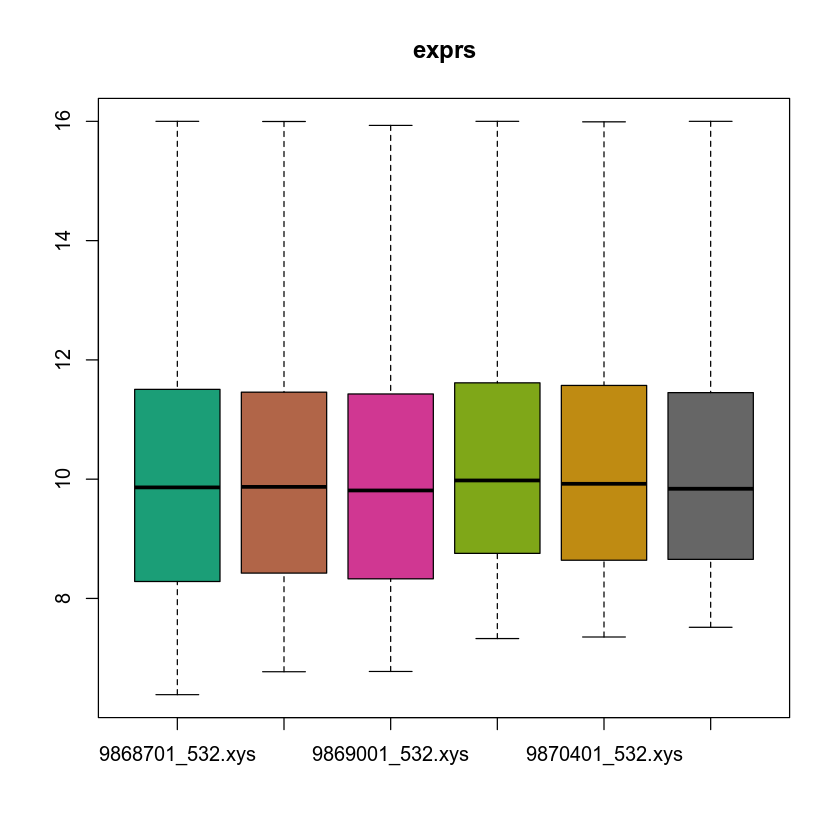

In [32]:
# Выводим boxplot с распределениями данных
oligo::boxplot(maqc)

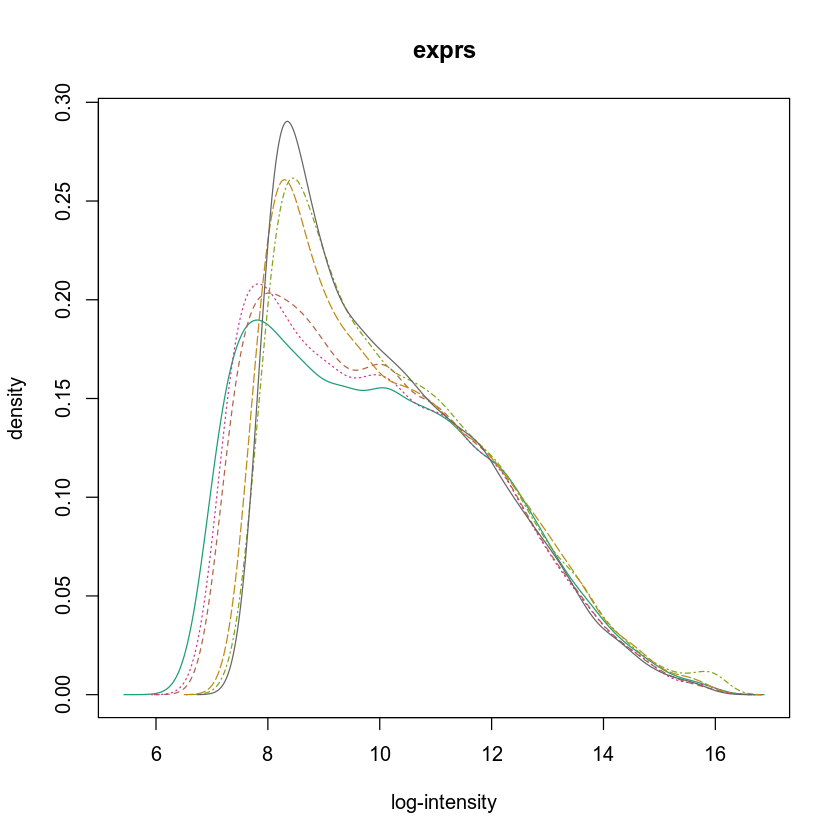

In [33]:
# гистограмма данных
oligo::hist(maqc)

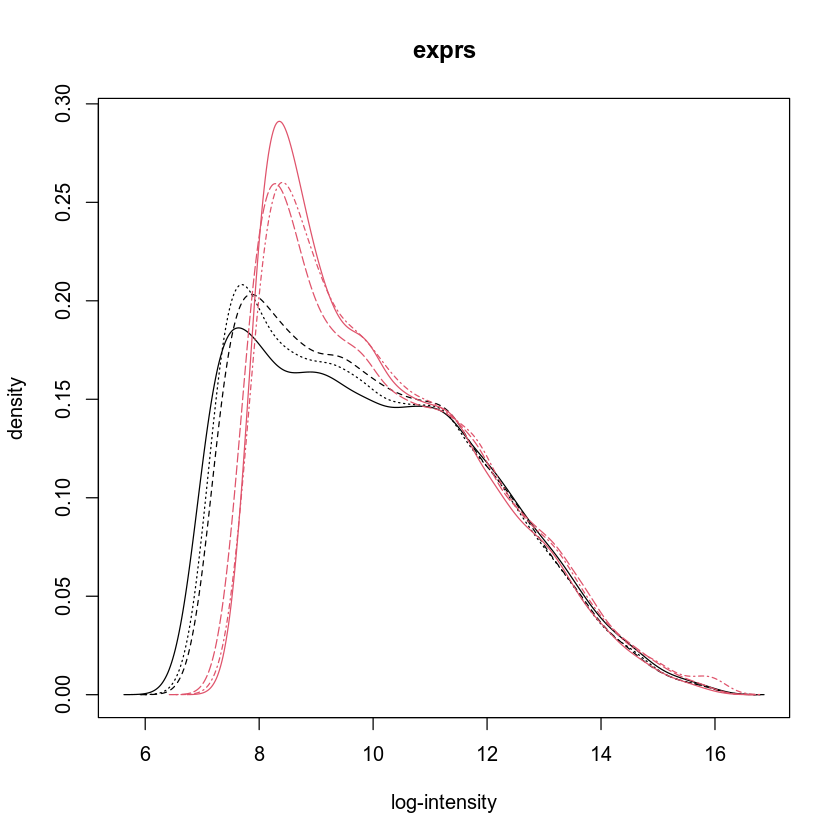

In [34]:
# гистограмма по классам
# Видно, что середнее значение у данных немного разное
# Это означает, что распределение у наших классов
# немного разное
oligo::hist(maqc, col=c(1, 1, 1, 2, 2, 2))

In [35]:
# Нормализуем данные с помощью метода RMA
# Подробнее про этот метод можно прочитать в ноутбуке Normalization
eset <- oligo::rma(maqc)

Background correcting
Normalizing
Calculating Expression


In [37]:
# Посморим, как унас нормализовались данные
# Заметьте, что пакет oligo сам перевел id генов в удобочитаемый формат
head(Biobase::exprs(eset))

,9868701_532.xys,9868901_532.xys,9869001_532.xys,9870301_532.xys,9870401_532.xys,9870601_532.xys
NM_000014,12.286393,12.272719,12.200675,13.293829,13.463383,13.342834
NM_000015,4.455020,4.625539,4.983707,4.979084,4.953028,5.191547
NM_000016,12.386405,12.203391,12.371974,12.740467,12.747468,12.572569
NM_000017,8.516991,8.541788,8.788435,9.275252,9.528687,9.333948
NM_000018,12.578168,12.414070,12.532205,13.211555,13.380439,13.240004
NM_000019,11.698035,11.636985,11.716222,12.508471,12.624998,12.553513


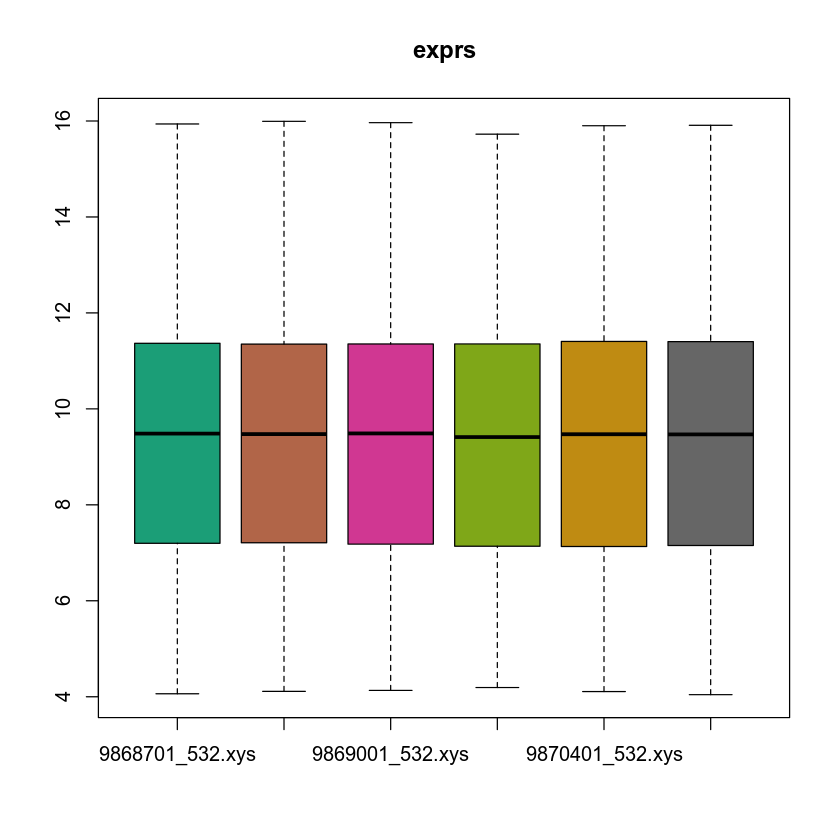

In [38]:
# Как мы видим, среднии значения у классов
# стали примерно равными
boxplot(eset)

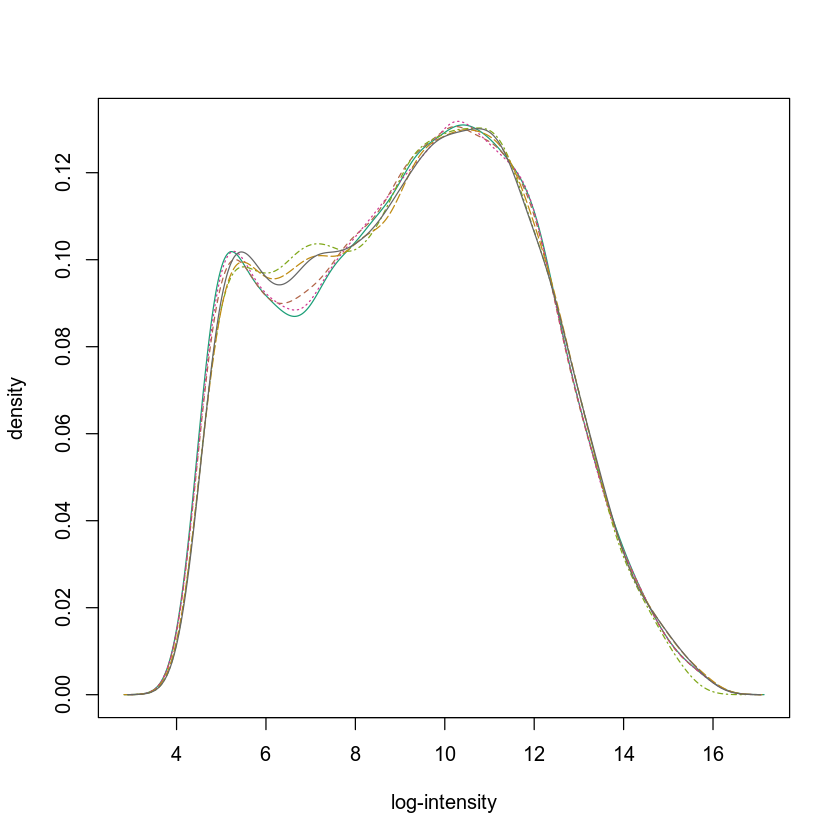

In [39]:
# При этом гистограмма у обоих классов
# стала больше двугорбовая
hist(eset)

In [45]:
# Получаем экспрессию генов с помощью функции exprs
exprs.data <- Biobase::exprs(eset)

In [47]:
# Вычисляем PCA c помощью функции prcomp
# Функция t транспонирует матрицу
PCA_raw <- stats::prcomp(t(exprs.data), scale. = FALSE)

# Выводим информацию о посчитанных главных компонентах
summary(PCA_raw)

Importance of components:
                           PC1      PC2      PC3      PC4      PC5       PC6
Standard deviation     154.619 15.85871 13.72867 12.36662 11.03457 1.359e-13
Proportion of Variance   0.971  0.01021  0.00765  0.00621  0.00495 0.000e+00
Cumulative Proportion    0.971  0.98119  0.98884  0.99505  1.00000 1.000e+00

In [74]:
# Вычисляем среденее отклонение по каждому вектору
percentVar <- summary(PCA_raw)$importance[2,]
percentVar

PC1     PC2     PC3     PC4     PC5     PC6 
0.97097 0.01021 0.00765 0.00621 0.00495 0.00000

In [84]:
# Выбираем первые 2 компоненты
dataGG <- data.frame(PC1 = PCA_raw$x[,1], PC2 = PCA_raw$x[,2])
dataGG

,PC1,PC2
,<dbl>,<dbl>
9868701_532.xys,-141.5942,0.2541139
9868901_532.xys,-140.8695,-8.2564545
9869001_532.xys,-140.9714,8.1585660
9870301_532.xys,139.8521,-25.6122665
9870401_532.xys,142.0576,4.2809930
9870601_532.xys,141.5253,21.1750482


In [85]:
# Подключаем библиотеку ggplot
# для работы с графиками
library(ggplot2)

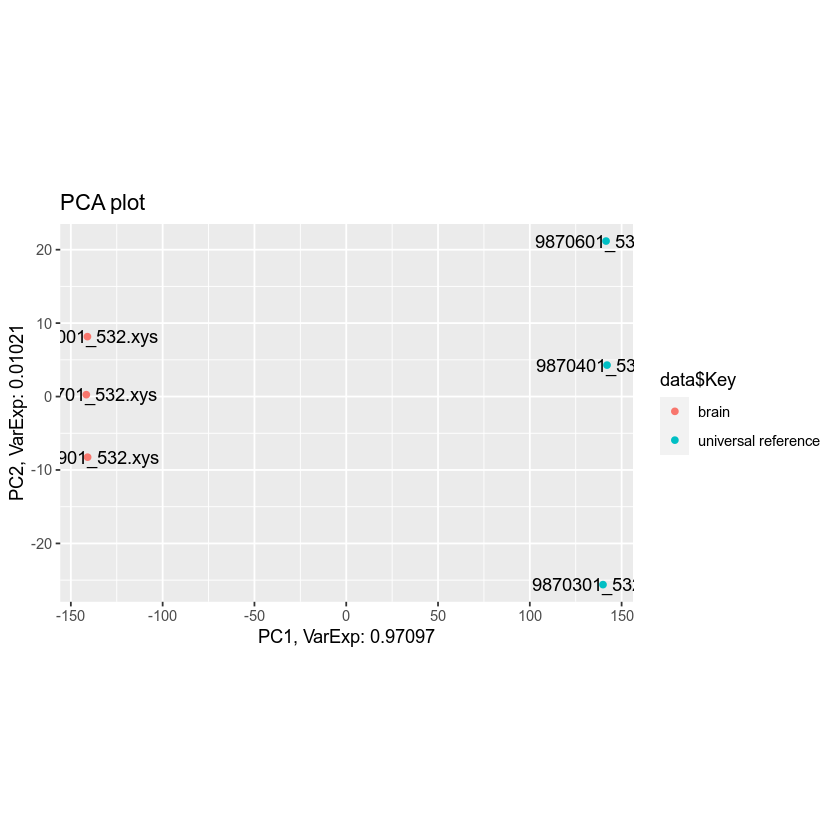

In [86]:
# Выводим PCA
# В основном все функции, которые написаны в этом блоке
# относятся к пакету ggplot2
# Здесь видно, что даже по первой компоненте классы хорошо разделяются

ggplot(dataGG, aes(PC1, PC2)) +
geom_point(aes(colour = data$Key)) +
geom_text(label = colnames(eset)) +
ggtitle("PCA plot") + 
xlab(paste0("PC1, VarExp: ", percentVar[1])) + 
ylab(paste0("PC2, VarExp: ", percentVar[2])) +
coord_fixed(ratio = 4)

### Heatmap, CLustermap

In [87]:
# Подключаем библиотку для отрисовки CLustermap
library(gplots)


Attaching package: ‘gplots’


The following object is masked from ‘package:IRanges’:

    space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:stats’:

    lowess




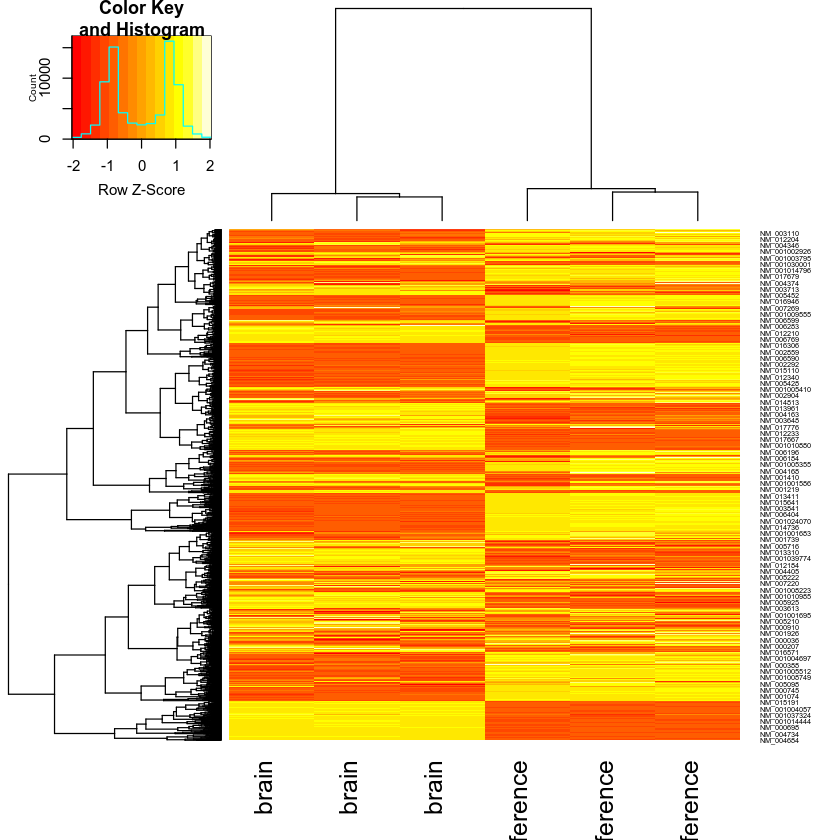

In [88]:
# Сократим кол-во данных, чтобы не занимать много памяти
s <- exprs.data[1:12000, 1:6]
colnames(s) <- data$Key

# С помощью heatmap.2.строим Clustermap
# trace='none' нужен для того, чтобы не выводить голубую линию
heatmap.2(s, scale='row', trace='none')

In [18]:
# BiocManager::install("edgeR")
# library(edgeR)

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:oligo’:

    backgroundCorrect


The following object is masked from ‘package:BiocGenerics’:

    plotMA




### Statistics 

Теперь перейдем к более сложному разделу - к статистике. В биоинформатике все построенно на статистике. Все сложные графики, интересные выводы из данных получаются благодаря статистике. Сейчас мы познакомимся с тем, как рассчитать базовые статистические величины из экспрессии генов

In [184]:
#Создаем группу
group <- c(rep("brain", 3), rep("reference", 3))
group <- as.factor(group)
table(group)

group
    brain reference 
        3         3 

In [185]:
# Создаем дизайн исследования
design <- model.matrix(~ 0 + group)
colnames(design) <- levels(group)
design

,brain,reference
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


In [200]:
# обучаем линейную модель на наших данных
fit <- limma::lmFit(exprs.data, design = design)

In [201]:
# смотрим, что у нас лежит в этой модели
names(fit)

[1] "coefficients"     "rank"             "assign"           "qr"              
 [5] "df.residual"      "sigma"            "cov.coefficients" "stdev.unscaled"  
 [9] "pivot"            "Amean"            "method"           "design"

In [202]:
# создаем contrast матрицу
n <- colnames(design)
cont.matrix <- limma::makeContrasts(brain - reference, levels=design)
cont.matrix

,brain - reference
brain,1
reference,-1


In [203]:
# Дообучаем модель
fit.cont <- limma::contrasts.fit(fit, cont.matrix)
names(fit.cont)

[1] "coefficients"     "rank"             "assign"           "qr"              
 [5] "df.residual"      "sigma"            "cov.coefficients" "stdev.unscaled"  
 [9] "pivot"            "Amean"            "method"           "design"          
[13] "contrasts"

In [204]:
# Считаем статистики по модели
fit.cont <- limma::eBayes(fit.cont)
names(fit.cont)

[1] "coefficients"     "rank"             "assign"           "qr"              
 [5] "df.residual"      "sigma"            "cov.coefficients" "stdev.unscaled"  
 [9] "pivot"            "Amean"            "method"           "design"          
[13] "contrasts"        "df.prior"         "s2.prior"         "var.prior"       
[17] "proportion"       "s2.post"          "t"                "df.total"        
[21] "p.value"          "lods"             "F"                "F.p.value"

In [205]:
# Смотрим на распределение экспрессии генов
summa.fit <- limma::decideTests(fit.cont)
summary(summa.fit)

       brain - reference
Down               10010
NotSig              5453
Up                  8537

In [206]:
# Выводит только самые значимые гены
# В coef пишем имя, которое мы давали колонкам в cont.matrix
stat <- limma::topTable(fit.cont, coef=colnames(cont.matrix), sort.by="p")
stat

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NM_021871,-8.513289,8.690249,-118.41418,6.065725e-13,3.827849e-09,19.04051
NM_000806,8.476382,8.601508,111.28880,9.413509e-13,3.827849e-09,18.81631
NM_000184,-8.563324,9.195145,-110.72598,9.757636e-13,3.827849e-09,18.79731
NM_021870,-9.084375,9.194213,-108.86015,1.100550e-12,3.827849e-09,18.73289
NM_014841,9.077481,10.074374,106.82013,1.258312e-12,3.827849e-09,18.65980
NM_005277,10.090787,9.892753,104.77864,1.442549e-12,3.827849e-09,18.58377
NM_001034,-8.318295,8.903851,-102.58414,1.675802e-12,3.827849e-09,18.49864
NM_002421,-7.271857,8.368350,-96.45235,2.592701e-12,3.827849e-09,18.24048
NM_007325,7.997233,9.064384,96.40369,2.601981e-12,3.827849e-09,18.23831


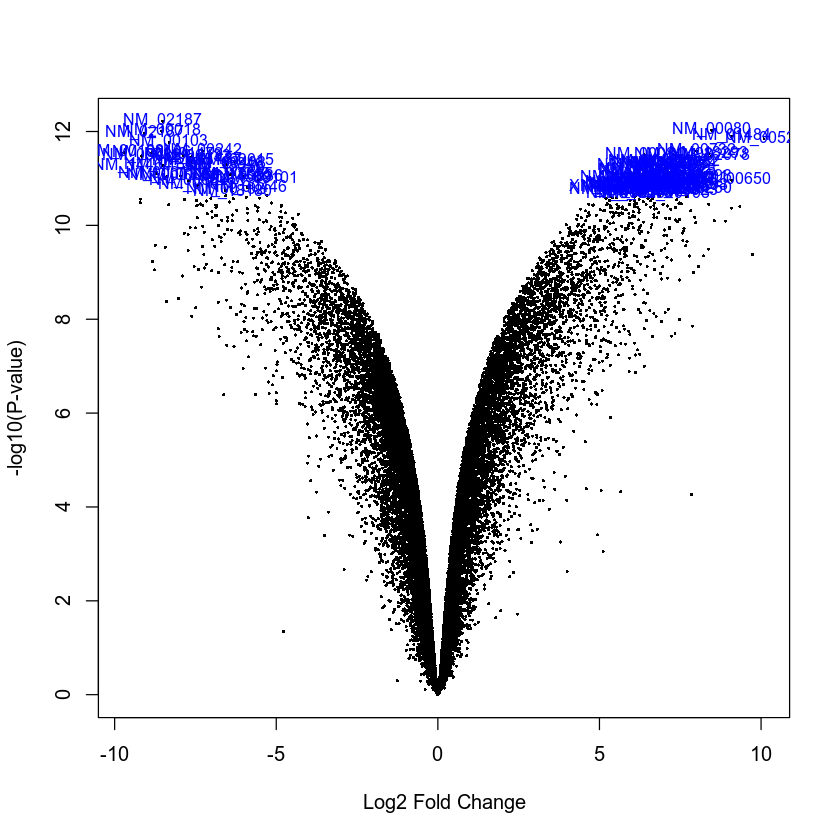

In [208]:
# Визуализируем все важные гены с помощью volcanoplot
# Подробнее об этом графике написано в ноутбуке GWAS
limma::volcanoplot(fit.cont,
                   coef = colnames(cont.matrix),
                   highlight = 100,
                   names  = rownames(fit.cont))

In [209]:
# Считаем статистики по всем генам
allStat <- limma::topTable(fit.cont,
                           coef = colnames(cont.matrix),
                           sort.by="p",
                           number = dim(fit.cont)[1])
head(allStat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NM_021871,-8.513289,8.690249,-118.4142,6.065725e-13,3.827849e-09,19.04051
NM_000806,8.476382,8.601508,111.2888,9.413509e-13,3.827849e-09,18.81631
NM_000184,-8.563324,9.195145,-110.7260,9.757636e-13,3.827849e-09,18.79731
NM_021870,-9.084375,9.194213,-108.8601,1.100550e-12,3.827849e-09,18.73289
NM_014841,9.077481,10.074374,106.8201,1.258312e-12,3.827849e-09,18.65980
NM_005277,10.090787,9.892753,104.7786,1.442549e-12,3.827849e-09,18.58377


In [210]:
summary(allStat)

     logFC              AveExpr             t                 P.Value         
 Min.   :-9.710443   Min.   : 4.213   Min.   :-118.41418   Min.   :0.0000000  
 1st Qu.:-0.855269   1st Qu.: 7.335   1st Qu.:  -7.80228   1st Qu.:0.0000013  
 Median :-0.081858   Median : 9.405   Median :  -0.69752   Median :0.0001874  
 Mean   : 0.006779   Mean   : 9.272   Mean   :   0.04658   Mean   :0.0825004  
 3rd Qu.: 0.719199   3rd Qu.:11.148   3rd Qu.:   6.28121   3rd Qu.:0.0254159  
 Max.   :10.090787   Max.   :15.792   Max.   : 111.28880   Max.   :0.9999678  
   adj.P.Val               B          
 Min.   :0.0000000   Min.   :-8.2536  
 1st Qu.:0.0000050   1st Qu.:-5.2129  
 Median :0.0003748   Median : 0.1644  
 Mean   :0.0890102   Mean   : 0.7770  
 3rd Qu.:0.0338874   3rd Qu.: 5.7694  
 Max.   :0.9999678   Max.   :19.0405  

In [167]:
# Записываем результат
write.csv(allStat, file = "../data/allStat.csv")